<a href="https://colab.research.google.com/github/hammaad2002/RHM_FYP/blob/main/Informer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **---------------INFORMER MODEL FOR TIME SERIES---------------**

**Importing dataset from Github and installing a package**

In [1]:
%%capture
!git clone https://github.com/hammaad2002/RHM_FYP

**Adding current path to python's system path also**

In [2]:
import sys
sys.path.append('/content/RHM_FYP/')

**Importing necessary libraries/packages**

In [3]:
import pandas as pd
from informer import Informer
import torch
import torch.nn as nn
import torch.optim as optim
import random
import math
import numpy as np
import matplotlib.pyplot as plt

**Importing data as dataframe**

In [4]:
df=pd.read_csv('/content/RHM_FYP/TurkeyWindFarm.csv')
df

,time,LV ActivePower (kW),Wind Speed (m/s),wind energy,Wind Direction (°)
0,1/1/2018 0:00,380.047791,5.311336,416.328908,259.994904
1,1/1/2018 0:10,453.769196,5.672167,519.917511,268.641113
2,1/1/2018 0:20,306.376587,5.216037,390.900016,272.564789
3,1/1/2018 0:30,419.645904,5.659674,516.127569,271.258087
4,1/1/2018 0:40,380.650696,5.577941,491.702972,265.674286
...,...,...,...,...,...
52555,12/31/2018 23:10,2963.980957,11.404030,3397.190793,80.502724
52556,12/31/2018 23:20,1684.353027,7.332648,1173.055771,84.062599
52557,12/31/2018 23:30,2201.106934,8.435358,1788.284755,84.742500
52558,12/31/2018 23:40,2515.694092,9.421366,2418.382503,84.297913


# **Data Preparation (using sliding window technique)**

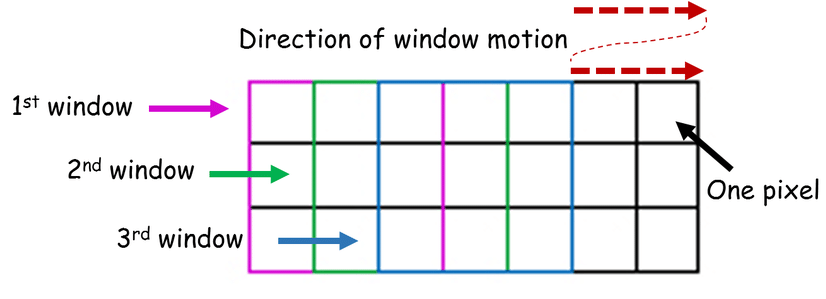

**Don't need time information in our case**

In [5]:
df.drop('time', inplace=True, axis=1)
df

,LV ActivePower (kW),Wind Speed (m/s),wind energy,Wind Direction (°)
0,380.047791,5.311336,416.328908,259.994904
1,453.769196,5.672167,519.917511,268.641113
2,306.376587,5.216037,390.900016,272.564789
3,419.645904,5.659674,516.127569,271.258087
4,380.650696,5.577941,491.702972,265.674286
...,...,...,...,...
52555,2963.980957,11.404030,3397.190793,80.502724
52556,1684.353027,7.332648,1173.055771,84.062599
52557,2201.106934,8.435358,1788.284755,84.742500
52558,2515.694092,9.421366,2418.382503,84.297913


**Normalizing data in between range [0,1]**

In [6]:
max_values = df.max()              #normalizing data in between range [0,1]
df = df.div(max_values) 
df

,LV ActivePower (kW),Wind Speed (m/s),wind energy,Wind Direction (°)
0,0.105022,0.210717,0.115647,0.722213
1,0.125394,0.225032,0.144422,0.746230
2,0.084664,0.206936,0.108583,0.757129
3,0.115965,0.224537,0.143369,0.753500
4,0.105189,0.221294,0.136584,0.737989
...,...,...,...,...
52555,0.819066,0.452433,0.943664,0.223620
52556,0.465454,0.290909,0.325849,0.233509
52557,0.608253,0.334657,0.496746,0.235397
52558,0.695186,0.373775,0.671773,0.234162


**Permuting columns so that we can split dataset easily**

In [7]:
#switching columns to make LV activePower (kW) last column so that it will be easy
# to prepare training and test datasets
cols = df.columns.tolist()
cols[0], cols[3] = cols[3], cols[0]
df = df[cols]
df

,Wind Direction (°),Wind Speed (m/s),wind energy,LV ActivePower (kW)
0,0.722213,0.210717,0.115647,0.105022
1,0.746230,0.225032,0.144422,0.125394
2,0.757129,0.206936,0.108583,0.084664
3,0.753500,0.224537,0.143369,0.115965
4,0.737989,0.221294,0.136584,0.105189
...,...,...,...,...
52555,0.223620,0.452433,0.943664,0.819066
52556,0.233509,0.290909,0.325849,0.465454
52557,0.235397,0.334657,0.496746,0.608253
52558,0.234162,0.373775,0.671773,0.695186


**Checking the shape of our target variable**

In [8]:
target=df['LV ActivePower (kW)']
target.shape

(52560,)

**Preparing our dataset in a sliding window fashion with a particular window size**

In [9]:
# Calculate the number of readings per day
readings_per_day = 144

#n = number of day
n = 3

# Calculate the sequence length (n days in readings)
sequence_length = readings_per_day * n

# Set the lookback window to be the same as the sequence length
lookback_window = sequence_length

# Convert the data to a NumPy array
df = df.values

x, y = [], []
for i in range(lookback_window, len(df)):
    x.append(df[i - lookback_window:i, :])
    y.append(df[i, -1])
x = np.array(x)
y = np.array(y)
print(x.shape)
print(y.shape)

(52128, 432, 4)
(52128,)


**Splitting our test and training part of dataset**

In [10]:
# Calculate the number of test samples (last 3 days of the year)
num_test_samples = readings_per_day * 3

# Split the data into training and test sets
x_train = x[:-num_test_samples]
y_train = y[:-num_test_samples]
x_test = x[-num_test_samples:]
y_test = y[-num_test_samples:]

**Checking the shape of our train and test set**

In [11]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(51696, 432, 4)
(51696,)
(432, 432, 4)
(432,)


# **Informer Model**

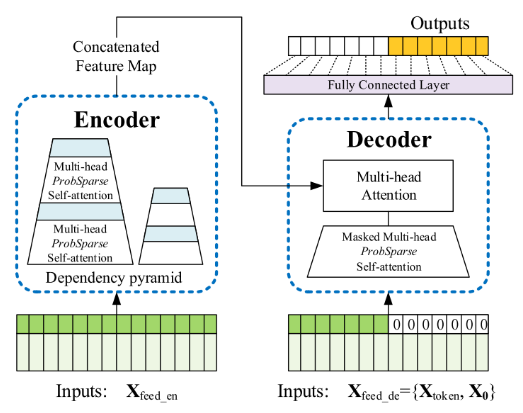

**Initializing Informer model by passing its parameters**

In [21]:
# Define model parameters
seq_length = lookback_window
input_size = x_train.shape[-1]
dim_model = 512
num_heads = 8
num_encoder_layers = 3
num_decoder_layers = 3
dropout_p = 0.2
out_size = 1

device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize the model
model = Informer(
    seq_len=seq_length, 
    label_len=1,
    pred_len=1,  # add pred_len argument
    distil=True,  # add distil argument
    enc_in=input_size, 
    dec_in=input_size, 
    c_out=out_size, 
    factor=5,
    d_model=dim_model, 
    n_heads=num_heads, 
    e_layers=num_encoder_layers, 
    d_layers=num_decoder_layers, 
    d_ff=2048, 
    dropout=dropout_p,
    activation='gelu',
    cardinality=[1],  # add cardinality argument
    output_attention=False,  # add output_attention argument
).to(device)

**Converting to tensors while also mounting them on the same device as the model**

In [13]:
# Convert data to tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

**Training the model after declaring optimizer, loss, metric and no. epochs**

In [14]:
rangee = 100
Xtemp = x_train_tensor[0:rangee]
Ytemp = y_train_tensor[0:rangee]

In [22]:
# Define loss function and optimizer
criterion_1 = nn.MSELoss()                                         # MSE
criterion_2 = nn.L1Loss()                                          # MAE (L1)
criterion_3 = nn.L1Loss()                                          # MAE
metricc = nn.L1Loss()                                              # MAPE metric
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)          # Adam

# Train the model
num_epochs = 1
batch_size = 1
lossInfo = []
metricInfo = []
for epoch in range(num_epochs):
    running_loss = 0.0               # MAE Loss
    running_metric = 0.0             # MAPE metric
    for i in range(0, len(Xtemp), batch_size):
        # Get batch of inputs and targets
        batch_x = x_train_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size]
        
        # Reshape input tensor
        batch_x = batch_x.view(-1, seq_length, input_size)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_x, batch_x, batch_x, batch_x) # provide the required arguments here
        loss = criterion_3(outputs.view(-1), batch_y)
        metric = metricc(outputs.view(-1), batch_y)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_metric += metric.item()
      
    epoch_loss = running_loss / (len(x_train) / batch_size)
    epoch_metric = running_metric / (len(x_train) / batch_size)
    lossInfo.append(epoch_loss)
    metricInfo.append(epoch_metric)
    print("-"*25, f"Epoch {epoch + 1}","-"*25)
    print(f"Epoch {epoch+1} MAE loss: {epoch_loss:.4f}")
    print(f"Epoch {epoch+1} MAPE metric: {epoch_metric:.4f}")

------------------------- Epoch 1 -------------------------
Epoch 1 MAE loss: nan
Epoch 1 MAPE metric: nan


**Plotting the loss and metric trend throughout the training of model**

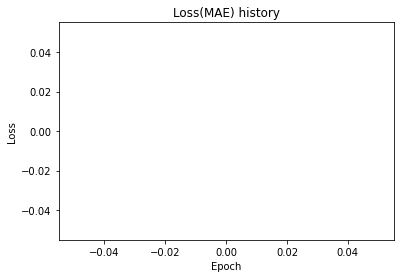

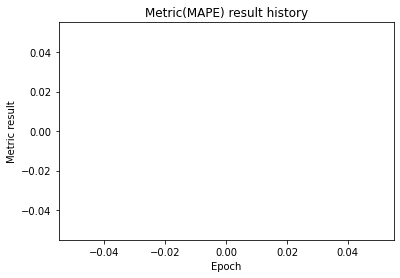

In [23]:
# Plot the history of loss
plt.plot(range(num_epochs), lossInfo)
plt.title('Loss(MAE) history')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot the history of metric result
plt.plot(range(num_epochs), metricInfo)
plt.title('Metric(MAPE) result history')
plt.xlabel('Epoch')
plt.ylabel('Metric result')
plt.show()

**Testing model performance on testset**

In [24]:
# Convert test data to tensor
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)

In [25]:
# Forward pass on test input tensor
with torch.no_grad():
    outputs = model(x_test_tensor[:rangee], x_test_tensor[:rangee], x_test_tensor[:rangee], x_test_tensor[:rangee])

# Reshape output tensor to (432,) shape
outputs = outputs.view(-1)

**Plotting the prediction of transformer on test with the ground truth**

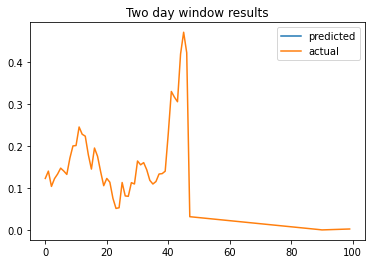

In [26]:
plt.plot(outputs.cpu().detach())
plt.plot(y_test[:rangee]) #denormalizing original data back
plt.title('Two day window results')
plt.legend(['predicted', 'actual'])
plt.show()

In [20]:
'''while True:
  pass'''

'while True:\n  pass'